In [1]:
#CHANGE THE PATH TO THE PATH AT YOUR PC!
path = "C:\\Users\\user\\Desktop\\TUe\\Topological\\Project\\Geolife Trajectories 1.3\\Data\\"
CITY_BORDERS = [40.19, 39.65, 115.98, 116.74]
#Optimal threshold for # of occurances per cell to be classified as a vetex - 600

import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Idea: for every trajectory, compute the ordered list of vertices encountered. Pairs of subsequently-visited vertices will span the edges of the graph

In [2]:
df = pd.read_csv(".\\presets\\very_short.csv")
#[(f, b) for f, b in zip(range(6), range(5))] #just an example

In [3]:
df

,latitude,longitude,altitude,date,trajectory,user,transportation
0,39.994622,116.326757,150,2008-10-27 19:54:52,0.200810,0,NaN
1,39.994614,116.326751,150,2008-10-27 19:54:54,0.200810,0,NaN
2,39.994602,116.326769,150,2008-10-27 19:54:59,0.200810,0,NaN
3,39.994599,116.326769,150,2008-10-27 19:55:04,0.200810,0,NaN
4,39.994599,116.326769,150,2008-10-27 19:55:07,0.200810,0,NaN
...,...,...,...,...,...,...,...
166955,39.986867,116.304267,65,2008-03-16 10:12:08,99.200803,99,NaN
166956,39.987133,116.305183,42,2008-03-16 10:13:19,99.200803,99,NaN
166957,39.987633,116.305267,90,2008-03-16 10:14:26,99.200803,99,NaN
166958,39.988183,116.306317,37,2008-03-16 10:16:10,99.200803,99,NaN


## This will be an attempt at the graphification - probably I won't do this in one go

In [4]:
class Cell():
    '''Just your regular Square kind of a class'''
    def __init__(self, top: float, left: float, bottom: float, right: float):
        self.top = top
        self.left = left
        self.bottom = bottom
        self.right = right
        self.number_of_locations = 0
        self.is_vertex = False
        
    def __str__(self):
        return "Cell: top = " + str(round(self.top, 5)) + ", left = " + str(round(self.left, 5)) + \
    ", bottom = " + str(round(self.bottom, 5)) + ", right = " + str(round(self.right, 5))

    def belongs(self, latitude: float, longitude: float):
        '''checks if a point belongs to the cell - pass the point as (y, x)'''
        return (latitude > self.bottom and latitude <= self.top and longitude < self.right and longitude >= self.left)
    
    def vertexize(self, threshold = 600):
        '''makes the Cell become a vertex if has more locations that threshold'''
        
        if self.number_of_locations > threshold:
            self.is_vertex = True

    

class Grid():
    '''pretty much just a list of Cells that is available at self.cell_list'''
    
    def __init__(self, latitude_cells_nr: int, longitude_cells_nr: int, city_borders = CITY_BORDERS):
        self.latitude_cells_nr = latitude_cells_nr
        self.longitude_cells_nr = longitude_cells_nr
        self.city_borders = city_borders
        
        self.latitude_cell_length = round((city_borders[0] - city_borders[1])/latitude_cells_nr, 5)
        self.longitude_cell_length = round((city_borders[3] - city_borders[2])/longitude_cells_nr, 5)
        
        self.cell_list = []
        for i in range(latitude_cells_nr):
            for j in range(longitude_cells_nr):
                self.cell_list.append(Cell(top=city_borders[1] + self.latitude_cell_length*i,
                                     left=city_borders[2] + self.longitude_cell_length*j,
                                     bottom=city_borders[1] + self.latitude_cell_length*(i+1),
                                     right=city_borders[2] + self.longitude_cell_length*(j+1)))
                
    def __str__(self):
        return "Grid of side length (latitude) " + str(self.latitude_cell_length) + \
    " and (longitude) " + str(self.longitude_cell_length) + " and total number of cells: " + \
    str(self.latitude_cells_nr*self.longitude_cells_nr)

        
    def feed_list_of_points(self, points: list):
        '''point is a tuple (y, x) - DO NOT MESS THE Y AND X UP!
        increase the number_of_locations for each cell, if the point belongs there'''
        
        for point in points:
            for cell in self.cell_list:
                if cell.belongs(point[0], point[1]):
                    cell.number_of_locations += 1
                    break
                    
                    
    def feed_list_of_cell_numbers(self, cell_numbers: list):
        '''for each cell number in the list, update the corresponding cell details'''
        
        for number in cell_numbers:
            self.cell_list[int(number)].number_of_locations += 1
            
    
    def vertexize(self, threshold):
        '''runs vertexize on each sell of the grid'''
        
        for cell in self.cell_list:
            cell.vertexize(threshold)
            
    def get_list_of_vertices(self) -> list:
        '''returns the numbers of all cells that are vertices (is_vertex() == True)'''
        
        return [i for i in range(len(self.cell_list)) if self.cell_list[i].is_vertex()]

In [5]:
grid = Grid(30, 30) 
print(grid)

Grid of side length (latitude) 0.018 and (longitude) 0.02533 and total number of cells: 900


In [6]:
print(grid.cell_list[0].number_of_locations)

0


In [7]:
def latitude_to_row(latitude: float, latitude_cells_number: int, 
                    latitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given latitude in the row of a datafame, checks which row number in the grid the point belongs to'''
    
    for i in range(latitude_cells_number):
        if latitude < CITY_BORDERS[1] + i*latitude_cell_length: #we do not have to check the other containment!
            return i
    

def longitude_to_column(longitude: float, longitude_cells_number: int, 
                        longitude_cell_length: float, CITY_BORDERS=CITY_BORDERS):
    '''For a given longitude in the row of a datafame, checks which column number in the grid the point belongs to'''
    
    for i in range(longitude_cells_number):
        if longitude < CITY_BORDERS[2] + i*longitude_cell_length: #we do not have to check the other containment!
            return i
        

def row_column_to_cell_number(row_nr: int, column_nr: int, longitude_cells_nr: int):
    '''given the x and y in the grid, calculates the cell number'''
    
    return row_nr*longitude_cells_nr + column_nr
# lambda x,y,z: x*y+z

In [8]:
#This will perform some expensive computation. Around 7s on the 160k dataset

df['column_number'] = df['latitude'].apply(latitude_to_row, args=(grid.latitude_cells_nr, 
                                                                  grid.latitude_cell_length, CITY_BORDERS))

df['row_number'] = df['longitude'].apply(longitude_to_column, args=(grid.longitude_cells_nr, 
                                                                    grid.longitude_cell_length, CITY_BORDERS))

df['cell_number'] = df.apply(lambda x: row_column_to_cell_number(x['column_number'], x['row_number'],
                                                                 grid.longitude_cells_nr),axis = 1)


df = df.drop(['column_number', 'row_number'], axis=1).dropna(subset='cell_number').reset_index(drop=True)

In [9]:
df

,latitude,longitude,altitude,date,trajectory,user,transportation,cell_number
0,39.994622,116.326757,150,2008-10-27 19:54:52,0.200810,0,NaN,614.0
1,39.994614,116.326751,150,2008-10-27 19:54:54,0.200810,0,NaN,614.0
2,39.994602,116.326769,150,2008-10-27 19:54:59,0.200810,0,NaN,614.0
3,39.994599,116.326769,150,2008-10-27 19:55:04,0.200810,0,NaN,614.0
4,39.994599,116.326769,150,2008-10-27 19:55:07,0.200810,0,NaN,614.0
...,...,...,...,...,...,...,...,...
157121,39.986867,116.304267,65,2008-03-16 10:12:08,99.200803,99,NaN,583.0
157122,39.987133,116.305183,42,2008-03-16 10:13:19,99.200803,99,NaN,583.0
157123,39.987633,116.305267,90,2008-03-16 10:14:26,99.200803,99,NaN,583.0
157124,39.988183,116.306317,37,2008-03-16 10:16:10,99.200803,99,NaN,583.0


In [10]:
THRESHOLD = 100 #for vertices
THRESHOLD_EDGES = 10

#This actually performs the large computation:
grid.feed_list_of_cell_numbers(list(df.cell_number))

#And this just switches some flags around:
grid.vertexize(THRESHOLD)

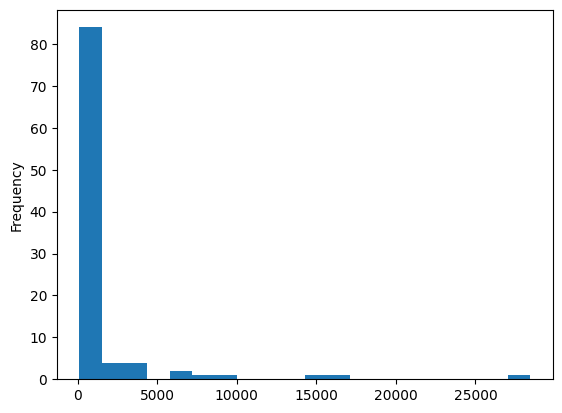

In [11]:
def plot_cell_containment(grid: Grid, threshold: int, bins = 20):
    ''''''
    wow = pd.Series([grid.cell_list[i].number_of_locations for i in range(grid.latitude_cells_nr*grid.longitude_cells_nr)])
    wow = pd.Series([wow[i] for i in range(len(wow)) if wow[i] > threshold])
    wow.plot(kind='hist', bins=bins)
    
plot_cell_containment(grid, threshold=THRESHOLD)

In [12]:
df_grouped = df.groupby('trajectory')

In [25]:
grid.cell_list[12].is_vertex

False

In [30]:
def find_subsequent_vertex_pairs(df_grouped) -> dict:
    '''if a trajectory has visited vertices: A, A, A, B, C, D, D; we will obtain
    (A, B), (B, C), (C, D) as the key of the resulting dictionary'''

    dic = {}
    
    #For each trajectory, get the list of unique cells it traversed:
    for element in df_grouped['cell_number'].unique():
        
        #Proceed if there was more than 1 cell that was traversed:
        if len(element)>1:
            
            #If the person went from a vertex to a vertex and not just ANY cell:
            if grid.cell_list[int(element[0])].is_vertex and grid.cell_list[int(element[1])].is_vertex:
                
                #Get all pairs of subsequent vertices
                list_of_pairs = [(int(element[i]), int(element[i+1])) for i in range(len(element)-1)]
                
                #Histogram code:
                for pair in list_of_pairs:
                    if pair not in dic:
                        dic[pair] = 1
                    else:
                        dic[pair] += 1

    return dic

In [31]:
edges_dict = find_subsequent_vertex_pairs(df_grouped)

In [32]:
edges_dict

{(614, 584): 41,
 (614, 644): 117,
 (554, 584): 101,
 (495, 494): 4,
 (467, 466): 1,
 (466, 437): 1,
 (436, 437): 3,
 (437, 465): 1,
 (465, 495): 1,
 (467, 437): 2,
 (437, 466): 1,
 (466, 436): 2,
 (437, 436): 4,
 (437, 467): 2,
 (584, 614): 48,
 (614, 615): 6,
 (617, 614): 1,
 (644, 614): 29,
 (525, 555): 12,
 (555, 554): 25,
 (615, 614): 1,
 (585, 584): 82,
 (585, 555): 54,
 (434, 435): 2,
 (435, 405): 1,
 (405, 375): 1,
 (375, 344): 1,
 (344, 314): 1,
 (314, 284): 1,
 (284, 254): 1,
 (254, 223): 1,
 (223, 193): 1,
 (193, 163): 1,
 (163, 164): 1,
 (164, 134): 1,
 (134, 135): 1,
 (135, 105): 1,
 (105, 106): 1,
 (106, 76): 1,
 (76, 47): 1,
 (47, 48): 1,
 (48, 18): 1,
 (18, 19): 1,
 (19, 20): 1,
 (20, 21): 1,
 (21, 22): 1,
 (22, 23): 1,
 (23, 24): 1,
 (24, 25): 1,
 (25, 26): 1,
 (26, 27): 1,
 (27, 28): 1,
 (28, 29): 1,
 (495, 525): 7,
 (377, 378): 2,
 (585, 586): 22,
 (586, 585): 23,
 (585, 615): 7,
 (586, 526): 1,
 (527, 526): 4,
 (584, 585): 110,
 (558, 528): 3,
 (616, 586): 8,
 (586,

In [16]:
edges = [key for key in edges_dict if edges_dict[key] > THRESHOLD_EDGES]

In [17]:
edges

[(614, 584),
 (614, 644),
 (554, 584),
 (584, 614),
 (644, 614),
 (525, 555),
 (555, 554),
 (585, 584),
 (585, 555),
 (585, 586),
 (586, 585),
 (584, 585),
 (616, 586),
 (556, 555),
 (584, 554),
 (555, 585),
 (587, 586),
 (558, 557),
 (584, 583),
 (554, 555),
 (555, 525),
 (584, 555),
 (613, 583),
 (583, 553),
 (583, 584),
 (553, 583),
 (553, 523),
 (554, 553),
 (644, 674),
 (583, 613),
 (587, 588),
 (589, 588),
 (586, 587),
 (588, 589),
 (650, 649),
 (649, 619),
 (589, 619),
 (734, 584),
 (648, 678),
 (678, 677),
 (678, 648),
 (553, 554),
 (554, 524),
 (524, 494),
 (500, 470),
 (585, 588),
 (475, 476),
 (673, 674),
 (674, 644),
 (674, 673),
 (673, 703),
 (734, 764),
 (764, 734),
 (734, 733),
 (584, 734),
 (524, 554),
 (589, 559)]

In [18]:
#     def feed_dataframe_of_points(self, df: pd.DataFrame):
#         '''point is a row with "latitude" as y and "longitude" as x - DO NOT MESS Y AND X UP!
#         increase the number_of_locations for each cell, if the point belongs there'''
        
#         #iterating over DataFrame's rows...unfortunately
#         for i in range(df.shape[0]):
            
#             #printing to see the progress:
#             if i % 25000 == 0:
#                 print(i)
                
#             for cell in self.cell_list:
#                 if cell.belongs(df.loc[i]["latitude"], df.loc[i]["longitude"]):
#                     cell.number_of_locations += 1
#                     break